In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IS4242 Group 1

Mounted at /content/drive
/content/drive/MyDrive/IS4242 Group 1


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Processing

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,12))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images/2+0.5,nrow=16).permute(1,2,0)) # images/2+0.5 to unnormalize images
    print(labels)
    break

In [ ]:
all_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
BATCH_SIZE = 32
path_train = "./codes/data/augmented"
train_set = ImageFolder(root=path_train, transform=all_transforms)
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
classes = list(train_set.class_to_idx.values())
train_set.class_to_idx

{'Apple_Green': 0,
 'Apple_Red': 1,
 'Banana': 2,
 'Capsicum_Green': 3,
 'Capsicum_Red': 4,
 'Capsicum_Yellow': 5,
 'Lemon': 6,
 'Orange': 7,
 'Pear': 8,
 'Tomato': 9}

tensor([8, 6, 3, 5, 4, 5, 5, 7, 3, 8, 6, 5, 5, 6, 5, 0, 4, 4, 8, 9, 3, 5, 2, 3,
        8, 4, 3, 1, 2, 6, 8, 3])


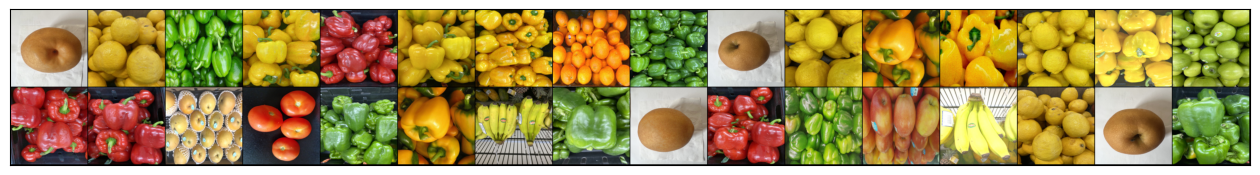

In [ ]:
show_batch(train_loader)

In [ ]:
path_val = './codes/data/val'
val_set = ImageFolder(root=path_val, transform=all_transforms)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)

tensor([2, 6, 4, 1, 0, 5, 4, 8, 0, 9, 9, 1, 6, 1, 3, 0, 9, 8, 3, 8, 5, 5, 7, 7,
        7, 3, 2, 2, 3, 6, 9, 4])


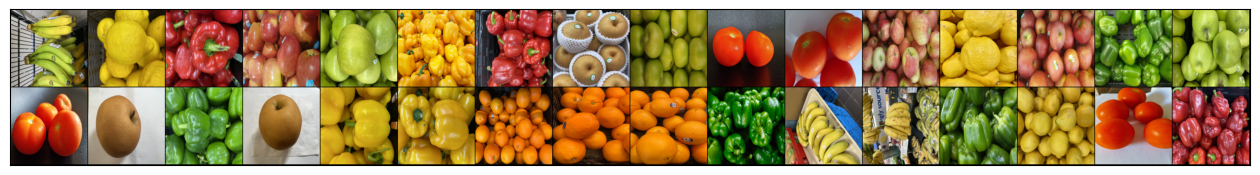

In [ ]:
show_batch(val_loader)

### Model

In [ ]:
class ConvNeuralNet(nn.Module):
	# Determine what layers and their order in CNN object 
  def __init__(self, num_classes):
    super(ConvNeuralNet, self).__init__()
    self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
    self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
    self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
    self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
    self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(179776, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, num_classes)
    
  # Progresses data across layers    
  def forward(self, x):
    out = self.dropout1(x)
    out = self.conv_layer1(out)
    out = self.conv_layer2(out)
    out = self.max_pool1(out)
        
    out = self.conv_layer3(out)
    out = self.conv_layer4(out)
    out = self.max_pool2(out)
                
    out = torch.flatten(out, 1) # Flatten all dimensions except batch
    
    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)
    return out

In [ ]:
def start_train_model(model, device, train_loader, valid_loader, optimizer, criterion, epoch, num_epochs):
  for batch_idx, (images, labels) in enumerate(train_loader):
    # Move tensors to the configured device (CPU or GPU)
    images = images.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

  # Validation
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      loss_val = criterion(outputs, labels)
      del images, labels, outputs

    print('Accuracy of the network on the {} validation images: {:.4f}%'.format(len(valid_loader.dataset), 100 * correct / total))
  
  return loss.item(), loss_val.item()

In [ ]:
def start_test_model(model, device, test_loader):
  model.eval()
  total = 0
  correct = 0
  labels_output = []
  predicted_output = []
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      # Calculate outputs of images by running through the model
      outputs = model(images)
      # Class with highest probability is chosen as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      labels_output.extend(labels.tolist())
      predicted_output.extend(predicted.tolist())
    print("Accuracy of the network on the {} images: {:.4f} %".format(len(test_loader.dataset), 100 * correct / total))
    return labels_output, predicted_output

### Model Training

In [ ]:
NUM_CLASSES = len(list(train_set.class_to_idx.values()))
EPOCHS = 10
LEARNING_RATE = 0.001

model = ConvNeuralNet(NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_loss_list = []
val_loss_list = []
for epoch in range(EPOCHS):
  train_loss, val_loss = start_train_model(model, DEVICE, train_loader, val_loader, optimizer, criterion, epoch, EPOCHS)
  train_loss_list.append(train_loss)
  val_loss_list.append(val_loss)

Epoch [1/10], Loss: 1.7225
Accuracy of the network on the 50 validation images: 56.0000%
Epoch [2/10], Loss: 0.3871
Accuracy of the network on the 50 validation images: 60.0000%
Epoch [3/10], Loss: 0.1702
Accuracy of the network on the 50 validation images: 74.0000%
Epoch [4/10], Loss: 0.0407
Accuracy of the network on the 50 validation images: 72.0000%
Epoch [5/10], Loss: 0.0071
Accuracy of the network on the 50 validation images: 72.0000%
Epoch [6/10], Loss: 0.0132
Accuracy of the network on the 50 validation images: 68.0000%
Epoch [7/10], Loss: 0.0046
Accuracy of the network on the 50 validation images: 70.0000%
Epoch [8/10], Loss: 0.0032
Accuracy of the network on the 50 validation images: 66.0000%
Epoch [9/10], Loss: 0.0033
Accuracy of the network on the 50 validation images: 68.0000%
Epoch [10/10], Loss: 0.0005
Accuracy of the network on the 50 validation images: 68.0000%


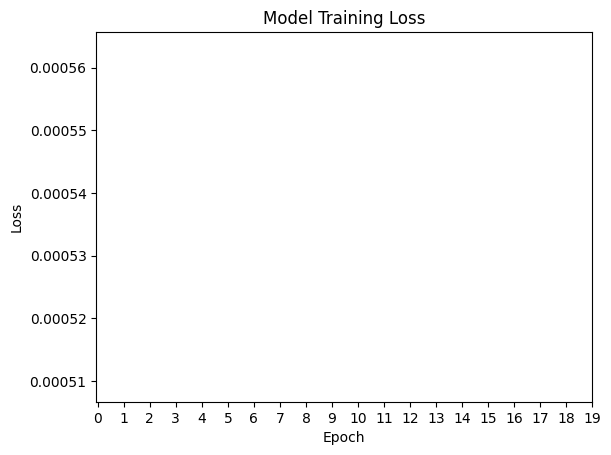

In [ ]:
plt.figure()
plt.plot(train_loss)
plt.xticks(np.arange(0,20,1))
plt.title("Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Model Evaluation

In [ ]:
y_labels, y_pred = start_test_model(model, DEVICE, train_loader)
cmat = confusion_matrix(y_labels, y_pred)
accuracy_per_class = (cmat.diagonal()/cmat.sum(axis=1)).tolist()
for class_ in range(len(accuracy_per_class)):
  print("Accuracy of class {}: {:.4f} %".format(class_, accuracy_per_class[class_]))
print(classification_report(y_labels, y_pred))

Accuracy of the network on the 63 images: 65.0794 %
Accuracy of class 0: 0.2857 %
Accuracy of class 1: 0.4286 %
Accuracy of class 2: 1.0000 %
Accuracy of class 3: 0.2857 %
Accuracy of class 4: 0.5714 %
Accuracy of class 5: 1.0000 %
Accuracy of class 6: 0.8571 %
Accuracy of class 7: 1.0000 %
Accuracy of class 8: 0.4286 %
              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       1.00      0.43      0.60         7
           2       0.37      1.00      0.54         7
           3       1.00      0.29      0.44         7
           4       1.00      0.57      0.73         7
           5       0.88      1.00      0.93         7
           6       0.55      0.86      0.67         7
           7       0.64      1.00      0.78         7
           8       1.00      0.43      0.60         7

    accuracy                           0.65        63
   macro avg       0.83      0.65      0.64        63
weighted avg       0.83     

In [ ]:
y_labels, y_pred = start_test_model(model, DEVICE, val_loader)
cmat = confusion_matrix(y_labels, y_pred)
accuracy_per_class = (cmat.diagonal()/cmat.sum(axis=1)).tolist()
for class_ in range(len(accuracy_per_class)):
  print("Accuracy of class {}: {:.4f} %".format(class_, accuracy_per_class[class_]))
print(classification_report(y_labels, y_pred))

Accuracy of the network on the 27 images: 40.7407 %
Accuracy of class 0: 0.0000 %
Accuracy of class 1: 0.0000 %
Accuracy of class 2: 1.0000 %
Accuracy of class 3: 0.0000 %
Accuracy of class 4: 0.0000 %
Accuracy of class 5: 1.0000 %
Accuracy of class 6: 0.6667 %
Accuracy of class 7: 1.0000 %
Accuracy of class 8: 0.0000 %
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.25      1.00      0.40         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.60      1.00      0.75         3
           6       0.40      0.67      0.50         3
           7       0.60      1.00      0.75         3
           8       0.00      0.00      0.00         3

    accuracy                           0.41        27
   macro avg       0.21      0.41      0.27        27
weighted avg       0.21     

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Save Model

In [ ]:
PATH = "./codes/weights/model.pth"
torch.save(model.state_dict(), PATH)